# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [87]:
import torch
from torch import nn
import torchvision
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-06-28 21:22:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  90.0MB/s    in 2.2s    

2022-06-28 21:22:35 (90.0 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge

rmodel = Ridge(alpha = 0.67, max_iter=10000, tol = 0.01, solver = 'cholesky')
rmodel.fit(X_train, y_train)

print(f"RMSE Train = {mse(y_train, rmodel.predict(X_train), squared = False)}")
print(f"RMSE Test = {mse(y_test, rmodel.predict(X_test), squared = False)}")

RMSE Train = 9.552822967904046
RMSE Test = 9.510160710091418


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

 **Посмотрим на распределение песен по годам.**

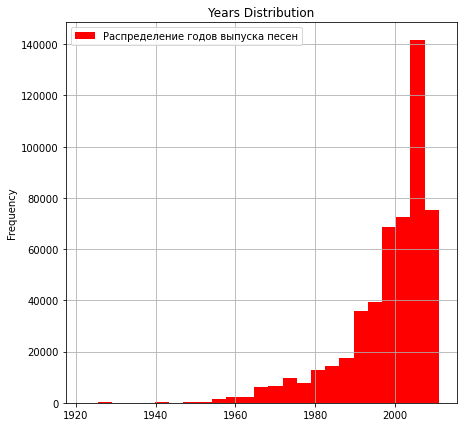

In [ ]:
df[0].plot(kind = 'hist',
           bins = 25,
           color = 'red', 
           figsize = (7, 7), 
           label = "Распределение годов выпуска песен",
           title = "Years Distribution", 
           grid = True,
           legend = True);

Распределение очень сильно напоминает __экспоненциальное__, только в обратную сторону. 

Посмотрим на логарифм этого распределения.

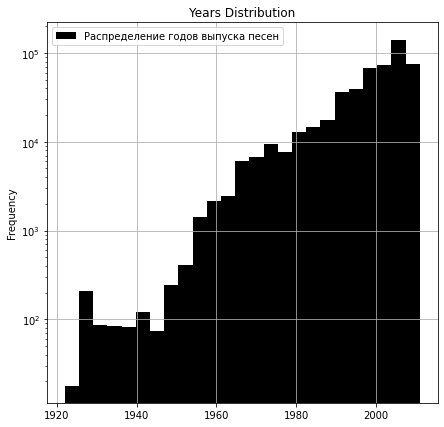

In [ ]:
df[0].plot(kind = 'hist',
           logy = True,
           bins = 25,
           color = 'black', 
           figsize = (7, 7), 
           label = "Распределение годов выпуска песен",
           title = "Years Distribution", 
           grid = True,
           legend = True);

Из такого распределения сложнее выявить какие-то зависимости, поэтому использовать логарифм целевой переменной смысла нет, будем обучаться на неизменненном таргете.

Посмотрим теперь на то, совпадают ли распределения таргета в обучающей и тренировочной выборках

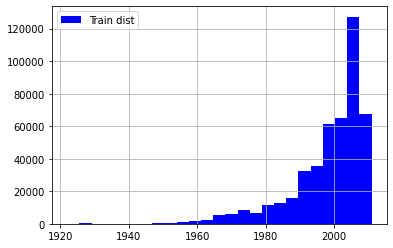

In [ ]:
plt.hist(x = y_train, bins = 25, color = 'blue', label = 'Train dist');
plt.legend()
plt.grid()

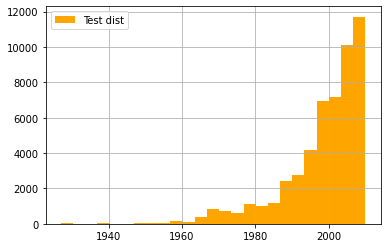

In [ ]:
plt.hist(x = y_test, bins = 25, color = 'orange', label = 'Test dist');
plt.legend()
plt.grid()

Распределения совпадают, все хорошо.

Теперь попробуем посмотреть на другие признаки. Но чтобы не перебирать все, рассмотрим 6 главных признаков согласно _Baseline_.

In [ ]:
from sklearn.inspection import permutation_importance

# проведем отбор сначала на обучающей выборке
r = permutation_importance(rmodel,  X_train, y_train, n_repeats = 5, scoring = 'neg_mean_squared_error')

for i in r.importances_mean.argsort()[::-1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 1:
          print(f"Index = {i} Importances =  "
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
          

print("-"*100)


# теперь на тестовой выборке
r = permutation_importance(rmodel,  X_test, y_test, n_repeats = 5, scoring = 'neg_mean_squared_error')

for i in r.importances_mean.argsort()[::-1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 1:
          print(f"Index = {i} Importances =  "
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")

Index = 0 Importances =  56.410 +/- 0.175
Index = 1 Importances =  16.612 +/- 0.069
Index = 5 Importances =  16.172 +/- 0.077
Index = 2 Importances =  4.669 +/- 0.053
Index = 22 Importances =  4.018 +/- 0.048
Index = 12 Importances =  2.210 +/- 0.019
Index = 26 Importances =  1.536 +/- 0.019
Index = 17 Importances =  1.380 +/- 0.023
Index = 7 Importances =  1.306 +/- 0.018
Index = 10 Importances =  1.034 +/- 0.017
Index = 8 Importances =  1.027 +/- 0.012
----------------------------------------------------------------------------------------------------
Index = 0 Importances =  52.479 +/- 0.359
Index = 1 Importances =  17.442 +/- 0.288
Index = 5 Importances =  15.580 +/- 0.147
Index = 2 Importances =  4.737 +/- 0.076
Index = 22 Importances =  4.527 +/- 0.103
Index = 12 Importances =  2.392 +/- 0.097
Index = 26 Importances =  1.699 +/- 0.070
Index = 17 Importances =  1.528 +/- 0.023
Index = 8 Importances =  1.395 +/- 0.043
Index = 10 Importances =  1.207 +/- 0.054
Index = 7 Importances 

Нам интересны признаки под индексами...

**[0, 1, 5, 2, 22, 12]**

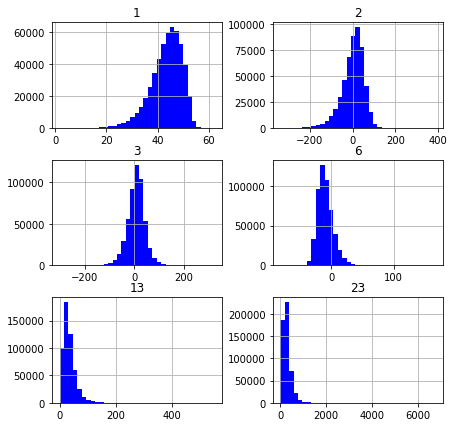

In [ ]:
intresting_index = [1, 2, 3, 6, 13, 23]
df[intresting_index].hist(bins = 35, figsize = (7, 7), facecolor = "blue");

Признаки на первых 4 картинках можно отнести к нормальному распределению, а последние 2 к экспоненциальному.

Наибольшую роль играет признак под индексом 0, его можно сверху ограничить нормальным распределением. Попробуем найти его параметры.

In [ ]:
print(f"Mean feature index 0 = {np.mean(df[1])}")
print(f"Varience feature index 0 = {np.var(df[1])}")

Mean feature index 0 = 43.387125625765265
Varience feature index 0 = 36.81519237690463


Таким образом, имеем гипотезу, что ключевым признаком будет признак под индексом 1 (в общем фрейме), его распределение нормальное со среднем 43,38 и дисперсией 36,81. __Именно таким распределением будем инициализировать первые скрытые слои сетки__. 

1 и 5 признаки примерно одинаковые по важности, посмотрим на распределение годов выпуска взависимости от этих признаков.

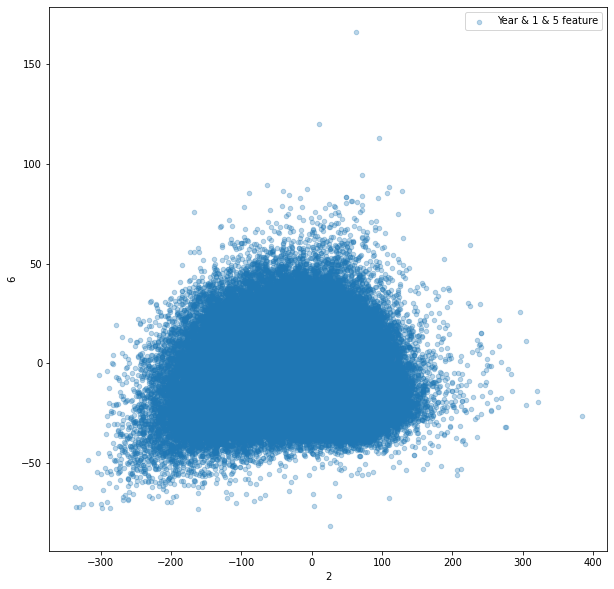

In [ ]:
_ = df.plot(kind = 'scatter',
            x = 2,
            y = 6,
            figsize = (10, 10),
            alpha = 0.3,
            label = 'Year & 1 & 5 feature');
_.legend()

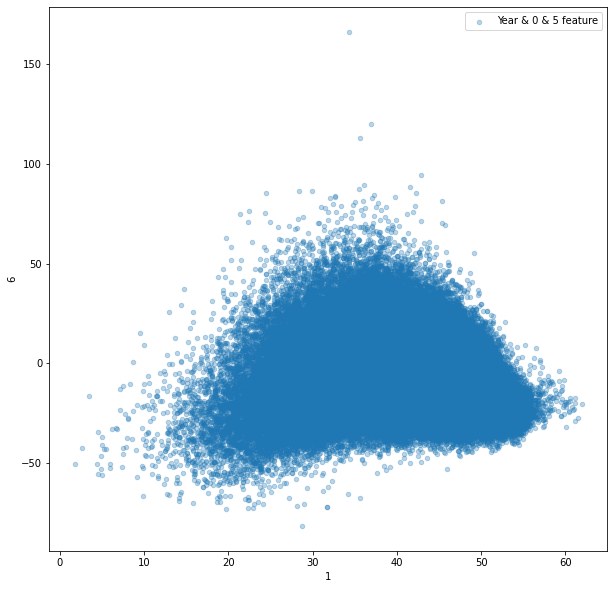

In [ ]:
_ = df.plot(kind = 'scatter',
            x = 1,
            y = 6,
            figsize = (10, 10),
            alpha = 0.3,
            label = 'Year & 0 & 5 feature');
_.legend()

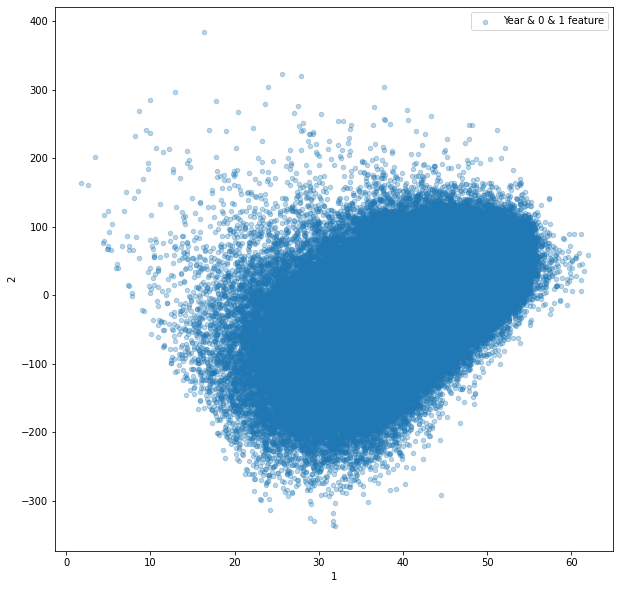

In [ ]:
_ = df.plot(kind = 'scatter',
            x = 1,
            y = 2,
            figsize = (10, 10),
            alpha = 0.3,
            label = 'Year & 0 & 1 feature');
_.legend()

Прослеживается линейная зависимость на последнем рисунке, но на 2 предыдущих такого нет. Построим корреляцию

In [ ]:
corr_matrix = df.corr()
corr_matrix[0].sort_values(ascending = False)

0     1.000000
1     0.225374
7     0.110460
47    0.096088
20    0.087057
        ...   
67   -0.102841
40   -0.123974
63   -0.126348
3    -0.139541
6    -0.187443
Name: 0, Length: 91, dtype: float64

Все те же самые наблюдения, что и выше. Попробуем построить таблицу ниже

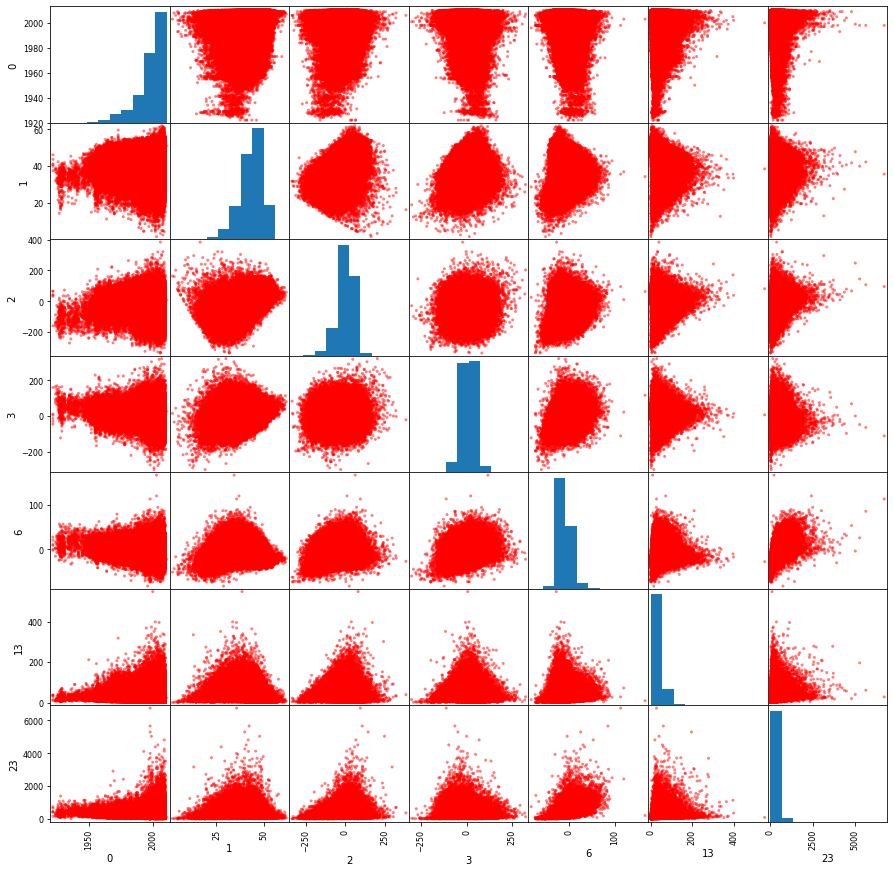

In [ ]:
from pandas.plotting import scatter_matrix
intresting_index = [0, 1, 2, 3, 6, 13, 23]
scatter_matrix(df[intresting_index], figsize = (15, 15), color = 'red');

Из интересного можно выделить зависимость года от 23 признака. Это самая скученная зависимость по сравнению с другими. 23 признак имеет экспоненциальное распределение.

**Гипотеза 2. Попробуем поставить экспоненциальное начальное распределение у некоторых скрытых слоев сети.**

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [82]:
from dataloader import YearPredictionDataSet

In [83]:
BATCHSIZE = 16

train_set = YearPredictionDataSet("data.txt.zip", train = True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCHSIZE, shuffle=True)

test_set = YearPredictionDataSet("data.txt.zip", train = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCHSIZE, shuffle=True)

In [ ]:
model = None # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = None # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = None # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [ ]:
# assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ